### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

# **README**

## **Overview**

For this coursework, we worked on the humour regression task (task 1). This notebook contains code for running our data analysis and experiments for Approach 2. The experiments for Approach 1 can be found in the accompanying colab notebook. The main sections of interest are "Data Analysis", "Approach 2" and "Comparison of approaches".

In general, the whole notebook can be run sequentially to reproduce the data analysis results and experiments mentioned in our report. The exception to this are the results for experimenting with different features individually in HumourNet and without FunLines. The notebook will train and evaluate HumourNet with our best performing combination of features if run as is, but the experiments for different features can be run by changing some flags. See the HumourNet section of the README for more details.

## **Data Analysis**

In this section, we investigated the Humicroedit dataset, investigating basic features such as the headline length by number of characters and words, the number of words replaced in each headline and the vocab size. We also looked at the relative edit position and statistics for the occurrences of 'Trump' and related mentions. The patterns we observed in this section helped to inform our approaches and the hand-crafted features we used in our approach 2.

##### **Reproducing data analysis results from report:**
Please run the cells in under the 'Data Analysis' section.

## **Approach 1**
See other Colab Notebook

## **Approach 2**

### **Initial TF-IDF Models**
Our initial approach was based off the second baseline provided, which used TF-IDF with linear regression. However, we noticed that it only made use of the edit word, so we extended the input to include the full headline before edit and full headline after edit, and passed this into other regression models, namely a Support Vector Machine with RBF kernel and Random Forest model.

##### **Reproducing experiments mentioned in report**
The original baseline can be found under `Baseline Models (Provided) > TF-IDF with Linear Regression`. Code for extending the input and our TF-IDF models can be found under `Approach 2 > TF-IDF with Other Regression Models`, with the cells for SVM and Random Forest clearly marked. To reproduce the experiments mentioned, run all cells up to and including the relevant cell in the notebook.

### **HumourNet**
This section contains the preprocessing and feature extraction functions we used, as well as the code for our main non-pretrained approach, HumourNet, and its variants.

Our preprocessing was based on what we observed in the dataset: for example, we observed some headlines were fully capitalised, and some had excessive whitespace, especially around punctuation. We performed lowercasing of all input, removed excessive whitespace, removed punctuation, and performed stop word removal. We also replaced variations of 'trump' such as 'president trump' and 'donald trump' in the replaced section with just 'trump' and concatenated the replaced section to be a single word.

We extracted features for i) mentions of trump ii) mentions of trump and hair iii) relative edit position iv) headline length v) cosine edit distance. We experimented with using each feature individually and with different combinations. Our final model uses features i), ii) and iii).

Our main approach, HumourNet, is designed to incorporate handcrafted features and takes as input the original and edit word, as well as our handcrafted features. It consists of 3 components:

1) Feature Encoder: Multi-layer FFNN processing our handcrafted features from the headline.

2) Word Encoder: Siamese network learning similarity between edit and original word.

3) Combining Neural Network: Multi-layer FFNN which takes concatenation of output from feature encoder and word encoder and outputs predicted humour grade.

#### **Reproducing experiments mentioned in report**
You can run our HumourNet experiments under the HumourNet section of this notebook. Make sure the previous sections of the notebook have been run. We have created the `features_map` and `present_components` maps so that you can run different experiments by setting the flags there. You can turn features on and off, and test the model with or without the feature and word encoder. In the same cell, you can also set `use_funlines` to adjust whether the model is trained with FunLines data. The configuration we have set in this notebook is the one used for our final, best performing model. 
The HumourNet variants (+ GloVe and + Byte Pair Encoding) can be run under their relevant subsections in the HumourNetwork section.


# Downloads & Setup

In [ ]:
# You will need to download any word embeddings required for your code, e.g.:

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

#! pip install torch

--2021-03-02 17:10:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-02 17:10:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-02 17:10:29--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# Imports

import re
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from collections import Counter, defaultdict
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt
import codecs
import string

In [ ]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Data

## Loading Data

In [ ]:
!git clone https://github.com/rampopat/humour-reg
print('Contents of git repo are the following files:')
!ls humour-reg
PATH_TO_DATA = 'humour-reg/'

Cloning into 'humour-reg'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 5), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.
Contents of git repo are the following files:
competition.png  README.md	       test.csv   train_funlines.csv
dev.csv		 task-1-humournet.csv  train.csv


In [ ]:
# Load data
train_df = pd.read_csv(PATH_TO_DATA + 'train.csv')
train_funlines_df = pd.read_csv(PATH_TO_DATA + 'train_funlines.csv')
val_df = pd.read_csv(PATH_TO_DATA + 'dev.csv')
test_df = pd.read_csv(PATH_TO_DATA + 'test.csv')
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [ ]:
print('Dataset sizes')
print(len(train_df), len(val_df), len(test_df), len(all_df))

Dataset sizes
9652 2419 3024 15095


## Data Analysis

### Headline Length

#### By number of characters

Distribution of headline lengths

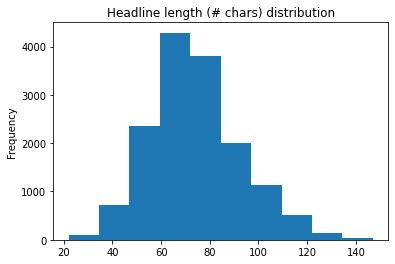

In [ ]:
all_df['original'].str.len().plot.hist()
plt.title("Headline length (# chars) distribution")
plt.show()

Max headline length

In [ ]:
max_headline_len = all_df['original'].str.len().max()
print('Max headline length is ' + str(max_headline_len))

Max headline length is 147


#### By number of words

Distribution of headline lengths (by # words)

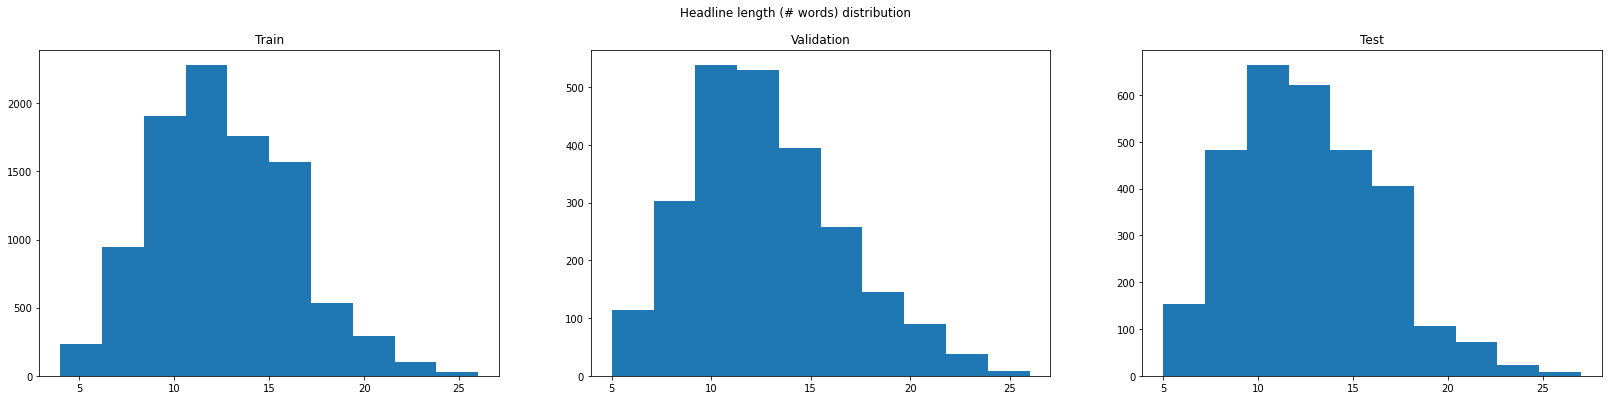

In [ ]:
train_headline_word_lens = [len(headline.split(" ")) for headline in train_df['original'].values]
val_headline_word_lens = [len(headline.split(" ")) for headline in val_df['original'].values]
test_headline_word_lens = [len(headline.split(" ")) for headline in test_df['original'].values]
fig, axs = plt.subplots(1, 3, figsize=(28, 6))
axs[0].hist(train_headline_word_lens)
axs[0].title.set_text('Train')
axs[1].hist(val_headline_word_lens)
axs[1].title.set_text('Validation')
axs[2].hist(test_headline_word_lens)
axs[2].title.set_text('Test')
plt.suptitle("Headline length (# words) distribution")
plt.show()

Min & max headline lengths (by # words)


In [ ]:
print("Max headline length: %d" % all_df['original'].str.split().apply(len).max())
print("Min headline length: %d" % all_df['original'].str.split().apply(len).min())
print("Mean headline length: %f" % all_df['original'].str.split().apply(len).mean())

Max headline length: 27
Min headline length: 4
Mean headline length: 12.316131


Relationship between headline length & funniness

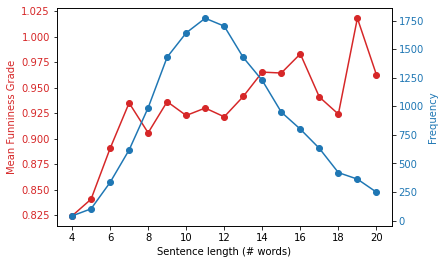

In [ ]:
def plot_len_vs_funniness(df):
  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('Sentence length (# words)')
  ax1.set_ylabel('Mean Funniness Grade', color=color)
  grades = df.groupby(df.original.str.split().apply(len))['meanGrade'].mean()
  grades = {len: grades[len] for len in range(4, 21)}
  ax1.plot(list(grades.keys()), list(grades.values()), color=color, marker='o')
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  
  color = 'tab:blue'
  ax2.set_ylabel('Frequency', color=color)
  freqs = df['original'].groupby(df['original'].str.split().apply(len)).count()
  freqs = {len: freqs[len] for len in range(4, 21)}
  ax2.plot(list(freqs.keys()), list(freqs.values()), color=color, marker='o')
  ax2.tick_params(axis='y', labelcolor=color)
  plt.show()

plot_len_vs_funniness(all_df)

### Replaced word counts

In [ ]:
counts = dict([(1, 0), (2, 0), (3, 0)])

for sentence in train_df['original']:
    tokenized_sentence = []
    replaced_words = re.findall("<(.*)/>", sentence)
    if len(replaced_words) > 0:
        replaced_word = replaced_words[0]
        split = replaced_word.split(' ')
        counts[len(split)] += 1

for c in counts.keys():
  print("Percentage of replaced words being a %d words: %.3f" % (c, 100 * counts[c] / len(train_df)))

Percentage of replaced words being a 1 words: 94.851
Percentage of replaced words being a 2 words: 4.921
Percentage of replaced words being a 3 words: 0.228


### Vocab size

In [ ]:
def get_vocab(df):
  vocab = set()
  for headline in pd.concat([df['original'], df['edit']]):
    vocab.update(headline.split())
  return vocab

train_vocab = get_vocab(train_df)
val_vocab = get_vocab(val_df)
test_vocab = get_vocab(test_df)

print("Number of unique words in training set: %d" % len(train_vocab))
print("Number of unique words in validation set: %d" % len(val_vocab))
print("Number of unique words in test set: %d" % len(test_vocab))
print("Number of words occurring in validation set not seen in training set: %d" % len(val_vocab.difference(train_vocab)))
print("Number of words occurring in test set not seen in training set: %d" % len(test_vocab.difference(train_vocab)))

Number of unique words in training set: 16801
Number of unique words in validation set: 6665
Number of unique words in test set: 7860
Number of words occurring in validation set not seen in training set: 2466
Number of words occurring in test set not seen in training set: 2986


In [ ]:
def get_vocab(df):
  vocab = set()
  vocab.update(df['original'].apply(lambda x: re.findall("<(.*)/>", x)[0]))
  vocab.update(df['edit'])
  return vocab

train_vocab = get_vocab(train_df)
val_vocab = get_vocab(val_df)
test_vocab = get_vocab(test_df)

print("Number of unique replaced/edit words in training set: %d" % len(train_vocab))
print("Number of unique replaced/edit words in validation set: %d" % len(val_vocab))
print("Number of unique replaced/edit words in test set: %d" % len(test_vocab))
print("Number of words occurring in validation set not seen in training set: %d" % len(val_vocab.difference(train_vocab)))
print("Number of words occurring in test set not seen in training set: %d" % len(test_vocab.difference(train_vocab)))

Number of unique replaced/edit words in training set: 7897
Number of unique replaced/edit words in validation set: 2940
Number of unique replaced/edit words in test set: 3505
Number of words occurring in validation set not seen in training set: 1286
Number of words occurring in test set not seen in training set: 1533


### Relative Edit Position
Values have been normalised according to sentence length

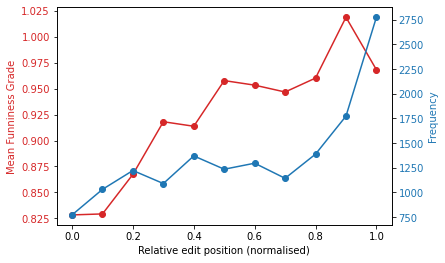

In [ ]:
def get_edit_pos_rounded(split_headline):
    for i, word in enumerate(split_headline):
      if word.startswith("<"):
        return round(i / (len(split_headline) - 1), 1)

def plot_edit_pos_vs_funniness(df):
  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('Relative edit position (normalised)')
  ax1.set_ylabel('Mean Funniness Grade', color=color)
  grades = df.groupby(df.original.str.split().apply(get_edit_pos_rounded))['meanGrade'].mean()
  ax1.plot(grades.keys(), grades.values, color=color, marker='o')
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  
  color = 'tab:blue'
  ax2.set_ylabel('Frequency', color=color)
  freqs = df['original'].groupby(df.original.str.split().apply(get_edit_pos_rounded)).count()
  ax2.plot(freqs.keys(), freqs.values, color=color, marker='o')
  ax2.tick_params(axis='y', labelcolor=color)
  plt.show()

plot_edit_pos_vs_funniness(all_df)

### Trump Word Statistics

In [ ]:
num_trump_mentions = train_df['original'].str.contains('Trump').sum()
percentage_trump = 100 * num_trump_mentions / len(train_df)
print("Percentage of rows containing trump: %.2f" % percentage_trump)

trump_headlines = train_df[train_df['original'].str.contains('trump', flags=re.IGNORECASE)]
trump_edits = train_df[train_df['edit'].str.contains('trump', flags=re.IGNORECASE)]
trump_rows = pd.concat([trump_headlines, trump_edits], axis=0)
trump_rows_funny = trump_rows[trump_rows['meanGrade'] > 2.0]
print("Percentage of trump rows being very funny: %.2f" % (100 * len(trump_rows_funny) / len(trump_rows)))

trump_hair_rows = trump_rows[trump_rows['edit'].str.contains('hair', flags=re.IGNORECASE)]
trump_hair_rows_funny = trump_hair_rows[trump_hair_rows['meanGrade'] > 2.0]
print("Percentage of trump and hair rows being very funny: %.2f" % (100 * len(trump_hair_rows_funny) / len(trump_hair_rows)))


Percentage of rows containing trump: 38.81
Percentage of trump rows being very funny: 4.81
Percentage of trump and hair rows being very funny: 28.57


# Helper Functions

In [ ]:
# Number of epochs
epochs = 10

# Proportion of training data for train compared to dev
train_proportion = 0.8

In [ ]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, custom_input=False):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    
    print("Training model.")

    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:

            if custom_input:
                feature, orig_seq, edit_seq, target = batch
                feature, orig_seq, edit_seq, target = feature.to(device), orig_seq.to(device), edit_seq.to(device), target.to(device)
            else:
                feature, target = batch
                feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            if custom_input:
                predictions = model(feature, orig_seq, edit_seq).squeeze(1)
            else:
                predictions = model(feature).squeeze(1)

            optimizer.zero_grad()

            loss = loss_fn(predictions, target)

            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model, custom_input)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.4f} | Train MSE: {epoch_mse:.4f} | Train RMSE: {epoch_mse**0.5:.4f} | \
        Val. Loss: {valid_loss:.4f} | Val. MSE: {valid_mse:.4f} |  Val. RMSE: {valid_mse**0.5:.4f} |')

In [ ]:
# We evaluate performance on our dev set
def eval(data_iter, model, custom_input=False):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            if custom_input:
                feature, orig_seq, edit_seq, target = batch
                feature, orig_seq, edit_seq, target = feature.to(device), orig_seq.to(device), edit_seq.to(device), target.to(device)
            else:
                feature, target = batch
                feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            if custom_input:
                predictions = model(feature, orig_seq, edit_seq).squeeze(1)
            else:
                predictions = model(feature).squeeze(1)

            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [ ]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.4f} | RMSE: {rmse:.4f} |')

    return sse, mse

In [ ]:
def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list

    for sentence in data:

        tokenized_sentence = []

        for token in sentence.split(' '): # simplest split is

            tokenized_sentence.append(token)

        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

In [ ]:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''

    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    batch_features_len = [len(f) for f, l in batch]
    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels

class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

# Baseline Models (Provided)

### Bidirectional LSTM with Glove

In [ ]:
class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2)

        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)

        out = self.hidden2label(lstm_out[-1])
        return out

In [ ]:
## Approach 1 code, using functions defined above:

# We set our training data and test data
training_data = train_df['original']
test_data = test_df['original']

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)
test_vocab, test_tokenized_corpus = create_vocab(test_data)

# Creating joint vocab from test and train:
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data]))

print("Vocab created.")

# We create representations for our tokens
wvecs = [np.zeros(100)] # word vectors
word2idx = [('<unknown>', 0)] # word2index
idx2word = [(0, '<unknown>')]

# This is a large file, it will take a while to load in the memory!
with codecs.open('glove.6B.100d.txt', 'r','utf-8') as f:
  index = 1
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)

# Convert training corpus to vectors
vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in training_tokenized_corpus]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

INPUT_DIM = len(word2idx)
EMBEDDING_DIM = 100
BATCH_SIZE = 32

model = BiLSTM(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)
print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

feature = vectorized_seqs

# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset(feature, train_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())

train(train_loader, dev_loader, model, epochs)

Vocab created.
Model initialised.
Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.3891 | Train MSE: 0.3891 | Train RMSE: 0.6238 |         Val. Loss: 0.3480 | Val. MSE: 0.3480 |  Val. RMSE: 0.5899 |
| Epoch: 02 | Train Loss: 0.3364 | Train MSE: 0.3364 | Train RMSE: 0.5800 |         Val. Loss: 0.3510 | Val. MSE: 0.3510 |  Val. RMSE: 0.5925 |
| Epoch: 03 | Train Loss: 0.3213 | Train MSE: 0.3213 | Train RMSE: 0.5669 |         Val. Loss: 0.3565 | Val. MSE: 0.3565 |  Val. RMSE: 0.5970 |
| Epoch: 04 | Train Loss: 0.2947 | Train MSE: 0.2947 | Train RMSE: 0.5428 |         Val. Loss: 0.3552 | Val. MSE: 0.3552 |  Val. RMSE: 0.5960 |
| Epoch: 05 | Train Loss: 0.2675 | Train MSE: 0.2675 | Train RMSE: 0.5172 |         Val. Loss: 0.3673 | Val. MSE: 0.3673 |  Val. RMSE: 0.6060 |
| Epoch: 06 | Train Loss: 0.2502 | Train MSE: 0.2502 | Train RMSE: 0.5002 |         Val. Loss: 0.3778 | Val. MSE: 0.3778 |  Val. RMSE: 0.6147 |
| Epoch: 07 | Train Loss: 0.2381 | Train MSE: 0.2381 | Train RMSE

### TF-IDF with Linear Regression

In [ ]:
train_and_dev = train_df['edit']

# Just using edit word, doesn't take into account og headline
training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)

# Training model
regression_model = LinearRegression().fit(train_counts, training_y)

# Getting training set predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.1344 | RMSE: 0.3667 |

Dev performance:
| MSE: 0.3648 | RMSE: 0.6040 |


### Baseline from Mean
Predicts mean of training set regardless of input

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)


Baseline performance:
| MSE: 0.3390 | RMSE: 0.5823 |


# Approach 1: Uses retrained representations, see other colab notebook for this

# Approach 2: No pretrained representations

### TF-IDF with Other Regression Models (SVR, Random Forest)

First, we extend the input to include full headline before and after edit:

In [ ]:
# Create columns for full headline before & after edit
train_df["new"] = train_df.apply(
  lambda row: re.sub(r"<.+/>", row["edit"], row["original"]), axis=1
)
train_df["old"] = train_df["original"].str.replace(r"<(.+)/>", "\g<1>")

test_df["new"] = test_df.apply(
  lambda row: re.sub(r"<.+/>", row["edit"], row["original"]), axis=1
)
test_df["old"] = test_df["original"].str.replace(r"<(.+)/>", "\g<1>")

# We train a Tf-idf model for original and new headline
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(train_df['old'])
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)

count_vect_edited = CountVectorizer(stop_words='english')
train_counts_edited = count_vect_edited.fit_transform(train_df['new'])
transformer_edited = TfidfTransformer().fit(train_counts_edited)
train_counts_edited = transformer_edited.transform(train_counts_edited)

training_x = hstack((train_counts, train_counts_edited))
training_y = train_df['meanGrade']

# Processing test data
test_counts = count_vect.transform(test_df['old'])
test_counts = transformer.transform(test_counts)
test_counts_edited = count_vect_edited.transform(test_df['new'])
test_counts_edited = transformer_edited.transform(test_counts_edited)

testing_x = hstack((test_counts, test_counts_edited))
testing_y = test_df['meanGrade']

Linear Regression:

In [ ]:
# Training model
lr = LinearRegression().fit(training_x, training_y)

# Getting training set predictions
predicted_train = lr.predict(training_x)

# Test predictions
predicted = lr.predict(testing_x)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, testing_y, True)


Train performance:
| MSE: 0.0006 | RMSE: 0.0249 |

Dev performance:
| MSE: 548.8074 | RMSE: 23.4266 |


SVR:

In [ ]:
# Training model
svr = SVR().fit(training_x, training_y)

# Getting training set predictions
predicted_train = svr.predict(training_x)

# Test predictions
predicted = svr.predict(testing_x)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, testing_y, True)


Train performance:
| MSE: 0.0931 | RMSE: 0.3051 |

Dev performance:
| MSE: 0.3131 | RMSE: 0.5596 |


Random Forest Regressor:

In [ ]:
# Training model
rfr = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
rfr = rfr.fit(training_x, training_y)

# Getting training set predictions
predicted_train = rfr.predict(training_x)

# Test predictions
predicted = rfr.predict(testing_x)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, testing_y, True)


Train performance:
| MSE: 0.0494 | RMSE: 0.2223 |

Dev performance:
| MSE: 0.3345 | RMSE: 0.5783 |


## HumourNet

### Data Preprocessing Functions

In this section we have implemented some basic functions for preprocessing our data including punctuation removal, whitespace removal, and stop word removal. We also experimented with adding a preprocessing step which replaces variations of phrases containing 'trump' in the replacement section (eg: 'president trump', 'donald trump') with 'trump'.

In [ ]:
def remove_punct(headline):
  table = str.maketrans('', '', "!\"#$%&'()*+,-.:;=?@[\]^_`{|}~»‘’“”—")
  return headline.translate(table)


def remove_excessive_whitespace(headline):
  return re.sub(' +', ' ', headline).strip()


def remove_whitespace(edit_word):
  return edit_word.replace(" ", "")


def to_lower(headline):
  return headline.lower()


def remove_stop_words(headline):
  stop_words = set(["the", "a", "an", "that", "is", "and", "or", "its", "in", "m", "s", "t", "ll"])
    
  headline_SWR = []
  for token in headline.split(" "):
    if token not in stop_words and token != "":
        headline_SWR.append(token)

  return " ".join(headline_SWR)


def preprocess_replaced_word(headline):
    """
    1. Removes spaces in replaced word
    2. Convert all versions of trump to 'trump'
    """
    trump_regex = regexp = re.compile(r'\btrump\b')
    trump_vocab = 'trump'
    replaced_words = re.findall("<(.*)/>", headline)[0]
    if trump_regex.search(replaced_words):
        replaced_words = trump_vocab

    replaced_words = replaced_words.replace(" ", "")
    headline = re.sub("<(.*)/>", "<" + replaced_words + "/>", headline)
    return headline  


In [ ]:
def preprocess_fn(headline, punct_removal=True, whitespace_removal=True, stopword_removal=True, process_replaced_word=True):
  headline = headline.lower()

  if punct_removal:
    headline = remove_punct(headline)

  if whitespace_removal:
    headline = remove_excessive_whitespace(headline)

  if stopword_removal:
    headline = remove_stop_words(headline)

  if process_replaced_word:
    headline = preprocess_replaced_word(headline)

  return headline

def preprocess(df, punct_removal=True, whitespace_removal=True, stopword_removal=True, process_replaced_word=True):
  '''
    Creates new columns 'original_preprocessed' and 'edit_preprocessed' in dataframe
    contained preprocessed version of 'original' and 'edit' columns. Also creates new
    'replaced_vocab' column consisting of word(s) which are replaced in headline.
  '''
  df['original_preprocessed'] = df['original'].apply(preprocess_fn, args=(punct_removal, whitespace_removal, stopword_removal, process_replaced_word))
  df['edit_preprocessed'] = df['edit'].apply(preprocess_fn, args=(punct_removal, whitespace_removal, stopword_removal, False))
  df['replaced_vocab'] = df['original_preprocessed'].apply(lambda x: re.findall("<(.*)/>", x)[0])


### Feature Extraction

In [ ]:
# Calculates the relative position of the replaced word, normalised by the length of the sentence
# Assumes headline is cleaned (punctuation & whitespace removed)
def calc_relative_pos(headline):
  words = headline.split();
  max_word_index = len(words) - 1

  for i in range(max_word_index + 1):
    if re.match(r"<(.+)/>", words[i]):
      return i / max_word_index

    elif re.match(r"<(.+)", words[i]):
      # Multiple words replaced (assuming '<' char only appears for marking edited word)
      j = i + 1
      while j < max_word_index + 1:
        if re.match(r"(.+)/>", words[j]):
          return i / (max_word_index - (j - i))
        j += 1
  
  raise Exception("Failed to calculate relative position for headline: %s" % headline)


# Returns headline length scaled to be in range [0, 1]
def calc_headline_len(headline):
  MAX_LEN = 20 # Max headline length in data after preprocessing

  headline_len = 0
  for word in headline.split():
      headline_len += 1

  return headline_len/MAX_LEN


# Returns cosine distance between edit and edited word in embedding
def calc_edit_distance(original_embedded, edit_embedded):
  print(original_embedded)
  print(edit_embedded)
  cos = torch.tensordot(original_embedded, edit_embedded) / (torch.linalg.norm(original_embedded, dim=1) * torch.linalg.norm(edit_embedded, dim=1))
  print(cos)
  return cos


def contains_trump(headline):
  for word in headline.split():
    if word == 'trump':
      return 1
  return 0


def contains_trump_and_hair(headline):
  contains_trump = False
  contains_hair = False
  for word in headline.split():
    if word == 'trump':
      contains_trump = True
    if word == 'hair':
      contains_hair == True
  return int(contains_trump and contains_hair)


def extract_features(df, features_map, joint_vocab=None, word2idx=None):
  if features_map['relative_edit_pos']:
    df['relative_edit_pos'] = df.apply(
      lambda row: calc_relative_pos(row['original_preprocessed']), axis=1
    )
  if features_map['headline_length']:
    df["headline_length"] = df.apply(
      lambda row: calc_headline_len(row["original_preprocessed"]), axis=1
    )
  if features_map['trump']:
    df['trump'] = df.apply(
      lambda row: contains_trump(row["original_preprocessed"]), axis=1
    )
  if features_map['trump_hair']:
    df['trump_hair'] = df.apply(
      lambda row: contains_trump_and_hair(row["original_preprocessed"]), axis=1
    )
    
  if word2idx is not None:
    df['replaced_vocab_index'] = df.apply(lambda row: word2idx[row['replaced_vocab']] if row['replaced_vocab'] in word2idx else 0, axis=1)
    df['edit_vocab_index'] = df.apply(lambda row: word2idx[row['edit_preprocessed']] if row['edit_preprocessed'] in word2idx else 0, axis=1)
  elif joint_vocab is not None:
    df['replaced_vocab_index'] = df.apply(lambda row: joint_vocab.index(row['replaced_vocab']), axis=1)
    df['edit_vocab_index'] = df.apply(lambda row: joint_vocab.index(row['edit_preprocessed']), axis=1)

### HumorNet model

In [ ]:
class WordEncoder(nn.Module):
  def __init__(self, embedding_dim, dropout=0.5):
    super(WordEncoder, self).__init__()
    self.network = nn.Sequential(
        nn.Linear(embedding_dim, 64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.Dropout(dropout),
        nn.Tanh(),
    )
  
  def forward(self, x1, x2):
    out1 = self.network(x1)
    out2 = self.network(x2)
    dist = torch.abs(out1 - out2)
    return dist
  

class FeatureEncoder(nn.Module):
  def __init__(self, num_features=3):
    super(FeatureEncoder, self).__init__()
    self.network = nn.Sequential(
        nn.Linear(num_features, 16),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(16, 8),
        nn.Dropout(0.5),
        nn.ReLU()
    )

  def forward(self, x):
    return self.network(x)


class HumourNetwork(nn.Module):
  def __init__(
      self, 
      num_embeddings, 
      embedding_dim, 
      num_features, 
      use_edit_distance_feature, 
      use_word_encoder,
      use_feature_encoder,
      device
    ):
    super(HumourNetwork, self).__init__()
    self.word_encoder = WordEncoder(embedding_dim)
    self.feature_encoder = FeatureEncoder(num_features)
    self.num_features = num_features
    self.use_edit_distance_feature = use_edit_distance_feature
    self.embedding = nn.Embedding(num_embeddings, embedding_dim)
    self.use_word_encoder = use_word_encoder
    self.use_feature_encoder = use_feature_encoder
    self.device = device
    n = 0
    if use_word_encoder:
      n += 16
    if use_feature_encoder:
      n += 8
    self.linear = nn.Sequential(
        nn.Linear(n, 32),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(32, 1),
        nn.ReLU()
    )

  def init_hidden(self):
    pass

  def forward(self, x):
    train_replaced = x[:,-2]
    train_edit = x[:,-1]
    
    features = x[:,:self.num_features - self.use_edit_distance_feature].type(torch.FloatTensor).to(self.device)

    train_edit = self.embedding(train_edit)
    train_replaced = self.embedding(train_replaced)

    if self.use_edit_distance_feature:
      word_distance = calc_edit_distance(train_replaced, train_edit).unsqueeze(1)
      features = torch.cat((features, word_distance), dim=1)

    if self.use_word_encoder and self.use_feature_encoder:
      y_word = self.word_encoder.forward(train_edit, train_replaced)
      y_feature = self.feature_encoder.forward(features)
      concat_outputs = torch.cat((y_word, y_feature), dim=1)
      return self.linear(concat_outputs)
    
    if self.use_feature_encoder:
      y = self.feature_encoder.forward(features)
    
    if self.use_word_encoder:
      y = self.word_encoder.forward(train_edit, train_replaced)
    return self.linear(y)



### HumourNet Experiments

`present_componenets`: Experiment with and without different components of HumourNetwork. You need to set at least one encoder to `True`.

`features_map`: Experiment with different extracted features. Setting a feature to `True` feeds it into the feature encoder, whilst `False` doesn't.

`use_funlines`: Experiment with training using funlines dataset.

In [ ]:
present_components = {
    'word_encoder': True,
    'feature_encoder': True
}

features_map = {
    'trump': True, 
    'trump_hair': True, 
    'relative_edit_pos': True, 
    'headline_length': False,
    'cosine_edit_distance': False,
}

use_funlines = True

In [ ]:
if use_funlines:
    train_df_concat = pd.concat([train_df, train_funlines_df, val_df], axis=0)
else:
    train_df_concat = pd.concat([train_df, val_df], axis=0)
train_df_concat = train_df_concat.reset_index(drop=True)

num_features = sum(features_map.values())

preprocess(train_df_concat)
preprocess(test_df)

joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat(
    [train_df_concat['replaced_vocab'],
     test_df['replaced_vocab'],
     train_df_concat['edit_preprocessed'],
     test_df['edit_preprocessed']
    ]))

extract_features(train_df_concat, features_map, joint_vocab)
extract_features(test_df, features_map, joint_vocab)

# Get word embeddings for edit word and replaced word
INPUT_DIM = len(joint_vocab)
EMBEDDING_DIM = 100
BATCH_SIZE = 32

# 'feature' is a list of lists, each containing embedding IDs for word tokens
present_features = dict(filter(lambda item: item[1] and item[0] != 'cosine_edit_distance', features_map.items()))
columns = list(present_features.keys()) + ['replaced_vocab_index', 'edit_vocab_index']
train_and_dev = Task1Dataset(train_df_concat[columns].values.tolist(), train_df_concat['meanGrade'])
test = Task1Dataset(test_df[columns].values.tolist(), test_df['meanGrade'])

train_loader = torch.utils.data.DataLoader(train_and_dev, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

model = HumourNetwork(
    INPUT_DIM, 
    EMBEDDING_DIM, 
    num_features, 
    features_map['cosine_edit_distance'], 
    present_components['word_encoder'], 
    present_components['feature_encoder'],
    device
  )
model.to(device)

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train(train_loader, dev_loader, model, 10)

Training model.
| Epoch: 01 | Train Loss: 0.4600 | Train MSE: 0.4600 | Train RMSE: 0.6782 |         Val. Loss: 0.3529 | Val. MSE: 0.3529 |  Val. RMSE: 0.5940 |
| Epoch: 02 | Train Loss: 0.3917 | Train MSE: 0.3917 | Train RMSE: 0.6259 |         Val. Loss: 0.3304 | Val. MSE: 0.3304 |  Val. RMSE: 0.5748 |
| Epoch: 03 | Train Loss: 0.3744 | Train MSE: 0.3744 | Train RMSE: 0.6119 |         Val. Loss: 0.3287 | Val. MSE: 0.3287 |  Val. RMSE: 0.5734 |
| Epoch: 04 | Train Loss: 0.3697 | Train MSE: 0.3697 | Train RMSE: 0.6080 |         Val. Loss: 0.3282 | Val. MSE: 0.3282 |  Val. RMSE: 0.5729 |
| Epoch: 05 | Train Loss: 0.3601 | Train MSE: 0.3601 | Train RMSE: 0.6001 |         Val. Loss: 0.3258 | Val. MSE: 0.3258 |  Val. RMSE: 0.5708 |
| Epoch: 06 | Train Loss: 0.3568 | Train MSE: 0.3568 | Train RMSE: 0.5973 |         Val. Loss: 0.3244 | Val. MSE: 0.3244 |  Val. RMSE: 0.5695 |
| Epoch: 07 | Train Loss: 0.3483 | Train MSE: 0.3483 | Train RMSE: 0.5901 |         Val. Loss: 0.3227 | Val. MSE: 0.3227

#### Distribution of predictions

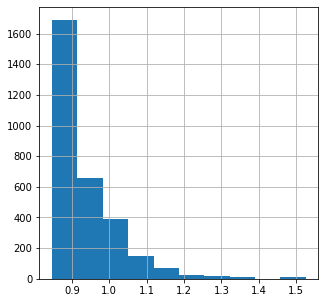

In [ ]:
_, _, preds, _ = eval(dev_loader, model)
pd.Series(preds).hist(figsize=(5, 5))

### HumourNet + GloVe

This falls under Approach 1 as it uses pre-trained GloVe representations. We wanted to see what difference in model performance using a pre-trained representation would give when applied to our HumourNet architecture. We felt the results were interesting to include, as they illustrate how pre-trained representations improve model performance - this is discussed further in our report.

In [ ]:
if use_funlines:
    train_df_concat = pd.concat([train_df, train_funlines_df, val_df], axis=0)
else:
    train_df_concat = pd.concat([train_df, val_df], axis=0)
train_df_concat = train_df_concat.reset_index(drop=True)

num_features = sum(features_map.values())

preprocess(train_df_concat)
preprocess(test_df)

joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat(
    [train_df_concat['replaced_vocab'],
     test_df['replaced_vocab'],
     train_df_concat['edit_preprocessed'],
     test_df['edit_preprocessed']
    ]))


# We create representations for our tokens
wvecs = [np.zeros(100)] # word vectors
word2idx = [('<unknown>', 0)] # word2index
idx2word = [(0, '<unknown>')]

with codecs.open('glove.6B.100d.txt', 'r','utf-8') as f:
  index = 1
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)

extract_features(train_df_concat, features_map, joint_vocab, word2idx)
extract_features(test_df, features_map, joint_vocab, word2idx)

# Get word embeddings for edit word and replaced word
INPUT_DIM = len(word2idx)
EMBEDDING_DIM = 100
BATCH_SIZE = 32

# 'feature' is a list of lists, each containing embedding IDs for word tokens
present_features = dict(filter(lambda item: item[1] and item[0] != 'cosine_edit_distance', features_map.items()))
columns = list(present_features.keys()) + ['replaced_vocab_index', 'edit_vocab_index']
train_and_dev = Task1Dataset(train_df_concat[columns].values.tolist(), train_df_concat['meanGrade'])
test = Task1Dataset(test_df[columns].values.tolist(), test_df['meanGrade'])

train_loader = torch.utils.data.DataLoader(train_and_dev, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

model = HumourNetwork(
    INPUT_DIM, 
    EMBEDDING_DIM, 
    num_features, 
    features_map['cosine_edit_distance'], 
    present_components['word_encoder'], 
    present_components['feature_encoder'],
    device
  )
model.to(device)

# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train(train_loader, dev_loader, model, 5)

Training model.
| Epoch: 01 | Train Loss: 0.5233 | Train MSE: 0.5233 | Train RMSE: 0.7234 |         Val. Loss: 0.3809 | Val. MSE: 0.3809 |  Val. RMSE: 0.6172 |
| Epoch: 02 | Train Loss: 0.4034 | Train MSE: 0.4034 | Train RMSE: 0.6351 |         Val. Loss: 0.3167 | Val. MSE: 0.3167 |  Val. RMSE: 0.5628 |
| Epoch: 03 | Train Loss: 0.3702 | Train MSE: 0.3702 | Train RMSE: 0.6084 |         Val. Loss: 0.3069 | Val. MSE: 0.3069 |  Val. RMSE: 0.5540 |
| Epoch: 04 | Train Loss: 0.3496 | Train MSE: 0.3496 | Train RMSE: 0.5913 |         Val. Loss: 0.3041 | Val. MSE: 0.3041 |  Val. RMSE: 0.5515 |
| Epoch: 05 | Train Loss: 0.3301 | Train MSE: 0.3301 | Train RMSE: 0.5746 |         Val. Loss: 0.3037 | Val. MSE: 0.3037 |  Val. RMSE: 0.5511 |


### HumourNet + Byte Pair Encoding

Creating vocab from corpus using byte pair encoding:

In [ ]:
def create_initial_vocab_bpe(data):
  # Returns frequency of tokens in corpus
  tokens = [" ".join(word) + " </w>" for sentence in data for word in sentence.split()]
  vocab = Counter(tokens)
  return vocab


def get_pair_counts(vocab):
  pairs = defaultdict(int)
  for word, freq in vocab.items():
      symbols = word.split()
      for i in range(len(symbols) - 1):
          pairs[symbols[i], symbols[i + 1]] += freq
  return pairs


def update_vocab(pair, vocab):
  new_vocab = {}
  bigram = re.escape(' '.join(pair))
  p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
  for word in vocab:
      # Replace most frequent pair
      w_out = p.sub(''.join(pair), word)
      new_vocab[w_out] = vocab[word]
  return new_vocab

    
def create_vocab_bpe(data):
  vocab = create_initial_vocab_bpe(data)
  num_merges = 50  # hyperparam
  for i in range(num_merges):
    pairs = get_pair_counts(vocab)
    best = max(pairs, key=pairs.get)
    vocab = update_vocab(best, vocab)

  vocab_bpe = []
  for word in vocab:
    for token in word.split():
      if token not in vocab_bpe:
        vocab_bpe.append(token)

  # <unk> is token for unknown 
  return ['<unk>'] + vocab_bpe


def tokenize_with_vocab(data, vocab):
  max_token_size = len(max(vocab, key=len))
  tokenized_corpus = []
  for sentence in data:
    tokenized_sentence = []
    sentence = "".join([word + "</w>" for word in sentence.split()])
    curr_index = 0
    while curr_index < len(sentence):
      for i in range(max_token_size, 0, -1):
        if curr_index + i > len(sentence):
          continue
        token = sentence[curr_index:curr_index + i]
        if token in vocab:
          tokenized_sentence.append(token)
          curr_index += i
          break
        elif i == 1:
          # Avoid infinite loop when cannot find next token
          print("Tokeniser error")
          tokenized_sentence.append("<unk>")
          curr_index += i
    tokenized_corpus.append(tokenized_sentence)
  return tokenized_corpus

Modifying HumourNet model to take sequence of tokens instead of just replaced & edit word:

In [ ]:
# Approach 2: HumourNetwork 

class SentenceEncoderBPE(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_dize, batch_size, device, dropout=0.5):
    super(SentenceEncoderBPE, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim
    self.device = device
    self.batch_size = batch_size

    # The LSTM takes word embeddings as inputs, and outputs hidden states
    # with dimensionality hidden_dim.
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

    # The linear layers that maps from hidden state space to tag space
    self.hidden2label = nn.Sequential(
        nn.Linear(hidden_dim * 2, 64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.Dropout(dropout),
        nn.Tanh(),
    )
    self.init_hidden(self.batch_size)


  def init_hidden(self, batch_size):
      # Before we've done anything, we dont have any hidden state.
      # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
      # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
      self.hidden1 = torch.zeros(2, batch_size, self.hidden_dim).to(self.device), \
              torch.zeros(2, batch_size, self.hidden_dim).to(self.device)
      self.hidden2 = torch.zeros(2, batch_size, self.hidden_dim).to(self.device), \
              torch.zeros(2, batch_size, self.hidden_dim).to(self.device)
  

  def forward(self, x1, x2):
    embedded1 = x1.permute(1, 0, 2)
    embedded2 = x2.permute(1, 0, 2)

    lstm_out1, self.hidden1 = self.lstm(
        embedded1.view(len(embedded1), x1.size(0), self.embedding_dim), self.hidden1)

    lstm_out2, self.hidden2 = self.lstm(
        embedded2.view(len(embedded2), x2.size(0), self.embedding_dim), self.hidden2)

    out1 = self.hidden2label(lstm_out1[-1])
    out2 = self.hidden2label(lstm_out2[-1])

    # This distance function can be changed
    dist = torch.abs(out1 - out2)

    return dist


class HumourNetworkBPE(nn.Module):
  def __init__(
      self, 
      num_embeddings, 
      embedding_dim, 
      num_features,
      use_sentence_encoder,
      use_feature_encoder,
      batch_size,
      device
    ):
    super(HumourNetworkBPE, self).__init__()
    self.sentence_encoder = SentenceEncoderBPE(embedding_dim, 50, num_embeddings, batch_size, device)
    self.feature_encoder = FeatureEncoder(num_features)
    self.num_features = num_features
    self.embedding = nn.Embedding(num_embeddings, embedding_dim)
    self.use_sentence_encoder = use_sentence_encoder
    self.use_feature_encoder = use_feature_encoder
    n = 0
    if use_sentence_encoder:
      n += 16
    if use_feature_encoder:
      n += 8
    self.linear = nn.Sequential(
        nn.Linear(n, 32),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(32, 1),
        nn.ReLU()
    )

  def init_hidden(self):
    self.sentence_encoder.init_hidden(self.batch_size)

  def forward(self, x, orig_headline, new_headline):
    train_replaced = x[:,-2]
    train_edit = x[:,-1]
    
    features = x[:,:self.num_features].type(torch.FloatTensor).to(device)

    orig_headline = self.embedding(orig_headline)
    new_headline = self.embedding(new_headline)

    if self.use_sentence_encoder and self.use_feature_encoder:
      y_sentence = self.sentence_encoder.forward(orig_headline, new_headline)
      y_feature = self.feature_encoder.forward(features)
      concat_outputs = torch.cat((y_sentence, y_feature), dim=1)
      return self.linear(concat_outputs)
    
    if self.use_feature_encoder:
      y = self.feature_encoder.forward(features)
    
    if self.use_sentence_encoder:
      y = self.sentence_encoder.forward(orig_headline, new_headline)
    return self.linear(y)

Create new collate_fn_padd_custom function to enable passing multiple inputs to network. Cannot be passed as single input because input tensor can't have different dimensions for features & sentence.

In [ ]:
def collate_fn_padd_custom(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''

    batch_labels = [l for f, l in batch]
    batch_features_const = [f[:-2] for f, l in batch]
    batch_features_orig = [f[-2] for f, l in batch]
    batch_features_edit = [f[-1] for f, l in batch]

    batch_features_orig_len = [len(f) for f in batch_features_orig]
    orig_tensor = torch.zeros((len(batch), max(batch_features_orig_len))).long()
    batch_features_edit_len = [len(f) for f in batch_features_edit]
    edit_tensor = torch.zeros((len(batch), max(batch_features_edit_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features_orig, batch_features_orig_len)):
        orig_tensor[idx, :seqlen] = torch.LongTensor(seq)

    for idx, (seq, seqlen) in enumerate(zip(batch_features_edit, batch_features_edit_len)):
        edit_tensor[idx, :seqlen] = torch.LongTensor(seq)
    
    features_tensor = torch.LongTensor(batch_features_const)

    batch_labels = torch.FloatTensor(batch_labels)

    return features_tensor, orig_tensor, edit_tensor, batch_labels

Training HumourNetwork + Byte Pair Encoding model

In [ ]:
present_components = {
    'sentence_encoder': True,
    'feature_encoder': True
}

features_map = {
    'trump': True, 
    'trump_hair': True, 
    'relative_edit_pos': True, 
    'headline_length': False,
    'cosine_edit_distance': False,
}

use_funlines = True

In [ ]:
if use_funlines:
    train_df_concat = pd.concat([train_df, train_funlines_df, val_df], axis=0)
else:
    train_df_concat = pd.concat([train_df, val_df], axis=0)
train_df_concat = train_df_concat.reset_index(drop=True)

preprocess(train_df_concat)
preprocess(test_df)
extract_features(train_df_concat, features_map)
extract_features(test_df, features_map)

# Get edited and original headlines
train_corpus_edited = train_df_concat.apply(
  lambda row: re.sub(r"<.+/>", row["edit"], row["original"]), axis=1
)
train_corpus_original = train_df_concat["original"].str.replace(r"<(.+)/>", "\g<1>")

test_corpus_edited = test_df.apply(
  lambda row: re.sub(r"<.+/>", row["edit"], row["original"]), axis=1
)
test_corpus_original = test_df["original"].str.replace(r"<(.+)/>", "\g<1>")

print("Creating vocab")
joint_vocab_bpe = create_vocab_bpe(pd.concat([train_corpus_original, train_df_concat['edit'], test_corpus_original, test_df['edit']]))

# Get embeddings for edited and original headlines
training_tokenized_corpus_original = tokenize_with_vocab(train_corpus_original, joint_vocab_bpe)
training_tokenized_corpus_edited = tokenize_with_vocab(train_corpus_edited, joint_vocab_bpe)
test_tokenized_corpus_edited = tokenize_with_vocab(test_corpus_edited, joint_vocab_bpe)
test_tokenized_corpus_original = tokenize_with_vocab(test_corpus_original, joint_vocab_bpe)

# Convert headlines to vectors
vectorized_seqs_train_orig = [[joint_vocab_bpe.index(tok) for tok in seq] for seq in training_tokenized_corpus_original]
vectorized_seqs_train_new = [[joint_vocab_bpe.index(tok) for tok in seq] for seq in training_tokenized_corpus_edited]
vectorized_seqs_test_orig = [[joint_vocab_bpe.index(tok) for tok in seq] for seq in test_tokenized_corpus_original]
vectorized_seqs_test_new = [[joint_vocab_bpe.index(tok) for tok in seq] for seq in test_tokenized_corpus_edited]

train_df_concat['orig_headline'] = vectorized_seqs_train_orig
train_df_concat['new_headline'] = vectorized_seqs_train_new
test_df['orig_headline'] = vectorized_seqs_test_orig
test_df['new_headline'] = vectorized_seqs_test_new

INPUT_DIM = len(joint_vocab_bpe)
EMBEDDING_DIM = 100
BATCH_SIZE = 32

present_features = dict(filter(lambda item: item[1] and item[0] != 'cosine_edit_distance', features_map.items()))
num_features = len(present_features)
columns = list(present_features.keys()) + ['orig_headline', 'new_headline']

train_and_dev = Task1Dataset(train_df_concat[columns].values.tolist(), train_df_concat['meanGrade'])
test = Task1Dataset(test_df[columns].values.tolist(), test_df['meanGrade'])

train_loader = torch.utils.data.DataLoader(train_and_dev, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd_custom)
dev_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd_custom)
model = HumourNetworkBPE(
    INPUT_DIM, 
    EMBEDDING_DIM, 
    num_features, 
    present_components['sentence_encoder'], 
    present_components['feature_encoder'],
    BATCH_SIZE,
    device
  )
model.to(device)

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
train(train_loader, dev_loader, model, 10, True)

Creating vocab
Training model.
| Epoch: 01 | Train Loss: 0.5373 | Train MSE: 0.5373 | Train RMSE: 0.7330 |         Val. Loss: 0.7892 | Val. MSE: 0.7892 |  Val. RMSE: 0.8884 |
| Epoch: 02 | Train Loss: 0.4276 | Train MSE: 0.4276 | Train RMSE: 0.6539 |         Val. Loss: 0.6076 | Val. MSE: 0.6076 |  Val. RMSE: 0.7795 |
| Epoch: 03 | Train Loss: 0.4101 | Train MSE: 0.4101 | Train RMSE: 0.6404 |         Val. Loss: 0.4854 | Val. MSE: 0.4854 |  Val. RMSE: 0.6967 |
| Epoch: 04 | Train Loss: 0.3937 | Train MSE: 0.3937 | Train RMSE: 0.6274 |         Val. Loss: 0.4062 | Val. MSE: 0.4062 |  Val. RMSE: 0.6373 |
| Epoch: 05 | Train Loss: 0.3823 | Train MSE: 0.3823 | Train RMSE: 0.6183 |         Val. Loss: 0.3568 | Val. MSE: 0.3568 |  Val. RMSE: 0.5973 |
| Epoch: 06 | Train Loss: 0.3740 | Train MSE: 0.3740 | Train RMSE: 0.6116 |         Val. Loss: 0.3345 | Val. MSE: 0.3345 |  Val. RMSE: 0.5783 |
| Epoch: 07 | Train Loss: 0.3690 | Train MSE: 0.3690 | Train RMSE: 0.6075 |         Val. Loss: 0.3280 | V

# Comparison of approaches

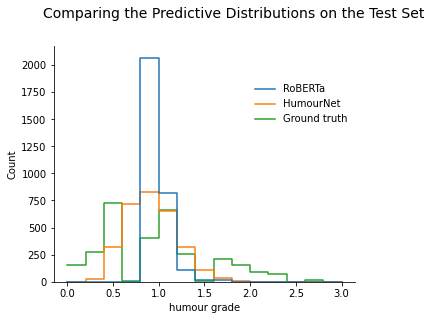

<Figure size 1200x800 with 0 Axes>

In [ ]:
df1 = pd.read_csv(PATH_TO_DATA + 'task-1-humournet.csv')
df2 = pd.read_csv(PATH_TO_DATA + 'task-1-roberta.csv')
test_df = pd.read_csv(PATH_TO_DATA + 'test.csv')

bins = 16
bin_edges, step = np.linspace(0, 3, bins, retstep=True)

df_concat = pd.concat([df1, df2, test_df['meanGrade']], keys=['RoBERTa','HumourNet', 'Ground truth']).reset_index(level=0)
df_melt = df_concat.melt(id_vars='level_0', var_name='var_id')
df_melt = df_melt[df_melt.var_id != "id"]

g = sns.displot(df_melt, kind='hist', x='value', hue='level_0',
                element='step', bins=bin_edges, fill=False, height=4, aspect=1.3,
                facet_kws=dict(sharex=False, sharey=False))

# Additional formatting
g.legend.set_bbox_to_anchor((0.75, 0.75))
g.legend.set_title('')
g.set(xlabel='humour grade')
plt.suptitle('Comparing the Predictive Distributions on the Test Set', x=0.5, y=1.1, fontsize=14)
plt.figure(dpi=200)
plt.show()


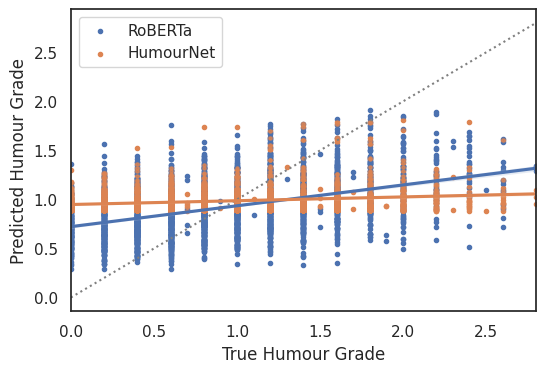

In [ ]:
labels = test_df['meanGrade'].to_numpy()
preds1 = pd.read_csv(PATH_TO_DATA + 'task-1-roberta.csv')['pred'].to_numpy()
preds2 = pd.read_csv(PATH_TO_DATA + 'task-1-humournet.csv')['pred'].to_numpy()

sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_style("white")

def get_pred_true_plot(preds1, preds2, labels, title):
    limits = [labels.min(), labels.max()]
    fig, ax = plt.subplots()
    fig.set_dpi(100)
    ax.set_title(title)
    ax.scatter(labels, preds1, marker='.', label='RoBERTa')
    ax.scatter(labels, preds2, marker='.', label='HumourNet')

    ax.plot(limits, limits, color="gray", linestyle=":")
    ax.set_xlabel('True Humour Grade')
    ax.set_ylabel('Predicted Humour Grade')
    sns.regplot(x=labels, y=preds1, ax=ax, scatter_kws={"s": 5})
    sns.regplot(x=labels, y=preds2, ax=ax, scatter_kws={"s": 5})
    plt.legend()
    plt.show()

get_pred_true_plot(preds1, preds2, labels, "")